In [1]:
%reset -f
import numpy as np
import pandas as pd
import random
import math
import os
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# Data load

In [3]:
mat = scipy.io.loadmat('NASAtrain_filtered.mat') #reads dataset for ICA
#mat = scipy.io.loadmat('NASAtrain_ICA_part.mat') #reads dataset for ICA
#mat = scipy.io.loadmat('NASAtrain_V.mat') #reads dataset for V segments
#mat = scipy.io.loadmat('NASAtrain_I.mat') #reads dataset for I segments
cellsName = [keys for keys in mat.keys() if not keys.startswith('__')]
numCell = len(cellsName)
print("mat structure:", numCell)
print("Name of cells:", cellsName)

mat structure: 4
Name of cells: ['train1', 'train2', 'train3', 'train4']


In [4]:
# Extract data from matalab to list in python
Sequences = []
Labels = []
Length_ICA = []
windows = 0

for i in range(numCell):
    mat[cellsName[i]][0][0].dtype.names
    mat[cellsName[i]][0][0]['data'][0][0].shape
    numCycle = len(mat[cellsName[i]][0][0]['data'])
    numCycle

    sequences = [[] for _ in range(numCycle)]
    label = [[] for _ in range(numCycle)]
    length = [[] for _ in range(numCycle)]

    for j in range(numCycle):
      sequences[j] =  torch.tensor(mat[cellsName[i]][0][0]['data'][j][0]).float() # list contain tensor sequences
      label[j] = torch.tensor(mat[cellsName[i]][0][0]['label'][j][0]).float()
      length[j] = len(mat[cellsName[i]][0][0]['data'][j][0][0])
      #print(f"size of ICA curves: {len(sequences)}")
    Sequences.extend(sequences)
    Labels.extend(label)
# The dataset include the packed datas(size = windows) in format of list
# All datas are already the tensor format
print(f"size of Data Sequences(s): {len(Sequences)} and labels: {len(Labels)}")
print(f"Typical shape of Dataset: {sequences[1].shape}")


size of Data Sequences(s): 636 and labels: 636
Typical shape of Dataset: torch.Size([3, 127])


torch.Size([3, 99])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 98])
torch.Size([3, 97])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 96])
torch.Size([3, 95])
torch.Size([3, 96])
torch.Size([3, 98])
torch.Size([3, 94])
torch.Size([3, 96])
torch.Size([3, 96])
torch.Size([3, 96])
torch.Size([3, 96])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 98])
torch.Size([3, 97])
torch.Size([3, 95])
torch.Size([3, 95])
torch.Size([3, 95])
torch.Size([3, 98])
torch.Size([3, 97])
torch.Size([3, 95])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 97])
torch.Size([3, 96])
torch.Size([3, 124])
torch.Size([3, 124])
torch.Size([3, 123])
torch.Size([3, 123])
torch.Size([3, 124])
torch.Size([3, 123])
torch.Size([3, 122])
torch.Size([3, 123])
torch.Size([3, 124])
torch.Size([3, 125])
torch.Size([3, 124])
torch.Size([3, 124])
torch.Size([3, 98])
torch.Size([3, 124])
torch.Size([3, 124])
torch.Size([3, 125])
torch.Size([3, 125])
torch.Size([3, 123])
torch.Size([3, 123])
to

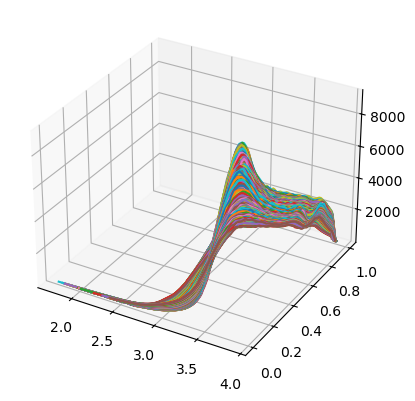

In [5]:
ax = plt.figure().add_subplot(projection='3d')

for i in range(len(Sequences)):
  print(Sequences[i].shape)
  ax.plot(np.array(Sequences[i][0]), np.array(Sequences[i][1]), np.array(Sequences[i][2]), label='ICA')  

# Model define

In [7]:
# Helper function to partition data
def trainingPartitions_3(numObservations, ratios):
    indices = np.arange(numObservations)
    np.random.shuffle(indices)
    train_end = int(ratios[0] * numObservations)
    val_end = train_end + int(ratios[1] * numObservations)
    return indices[:train_end], indices[train_end:val_end], indices[val_end:]

def trainingPartitions(numObservations, ratios):
    indices = np.arange(numObservations)
    np.random.shuffle(indices)
    train_end = int(ratios[0] * numObservations)
    return indices[:train_end], indices[train_end:]
       
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn_trim(batch):
    data_points, targets = zip(*batch)
    min_length = min(len(item[1]) for item in data_points)
    trimmed_sequences = [seq[:, :min_length] for seq in data_points]
    
    return trimmed_sequences, torch.tensor(targets)
    
    

numObservations = len(Sequences)
idxTrain, idxTest = trainingPartitions(numObservations, [0.8, 0.2])

XTrain = [Sequences[i] for i in idxTrain]
XTest = [Sequences[i] for i in idxTest]

TTrain = [Labels[i] for i in idxTrain]
TTest = [Labels[i] for i in idxTest]

print(f"Size of \n Train: {len(XTrain)} \n Test: {len(XTest)}")
print("--------------------------------------------------")
train_dataset = SequenceDataset(XTrain, TTrain)
test_dataset = SequenceDataset(XTest, TTest)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_trim)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn_trim)


print(f"batch num of train_loader: {len(train_loader)} \nbatch num of test_loader: {len(test_loader)}")
print("--------------------------------------------------")
X_batch, T_batch= next(iter(test_loader))
print("Example size of dataloader display:")
for i in range(len(X_batch)):
    print(f"{i+1}: \t{X_batch[i].shape} \t{T_batch[i]}" )

#for i in X_batch:
    #print(i.shape)


Size of 
 Train: 508 
 Test: 128
--------------------------------------------------
batch num of train_loader: 16 
batch num of test_loader: 4
--------------------------------------------------
Example size of dataloader display:
1: 	torch.Size([3, 95]) 	0.7041263580322266
2: 	torch.Size([3, 95]) 	0.7950183153152466
3: 	torch.Size([3, 95]) 	0.6607271432876587
4: 	torch.Size([3, 95]) 	0.9181517362594604
5: 	torch.Size([3, 95]) 	0.6427143216133118
6: 	torch.Size([3, 95]) 	0.6632843017578125
7: 	torch.Size([3, 95]) 	0.9950745701789856
8: 	torch.Size([3, 95]) 	0.8724439740180969
9: 	torch.Size([3, 95]) 	0.9187873601913452
10: 	torch.Size([3, 95]) 	0.7098456621170044
11: 	torch.Size([3, 95]) 	0.7634983658790588
12: 	torch.Size([3, 95]) 	0.7180752754211426
13: 	torch.Size([3, 95]) 	0.7740775346755981
14: 	torch.Size([3, 95]) 	0.6810652017593384
15: 	torch.Size([3, 95]) 	0.7125555276870728
16: 	torch.Size([3, 95]) 	0.7345755696296692
17: 	torch.Size([3, 95]) 	0.8626535534858704
18: 	torch.Siz

In [8]:
# Position Embedding Layer
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

# Transformer-based CNN-LSTM Model with attention mechanism
class CNN_LSTM(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding='same')
        self.self_attention = nn.MultiheadAttention(32, num_heads)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(32, num_hidden_units, batch_first=True)
        self.fc1 = nn.Linear(num_hidden_units, 9)
        self.fc2 = nn.Linear(9, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = x.transpose(1, 2)  # Convert to (batch, seq_length, channels)
        
        # Apply self-attention
        x = x.transpose(0, 1)  # Convert to (seq_length, batch, channels)
        x, attn_weights = self.self_attention(x, x, x)
        x = x.transpose(0, 1)  # Convert to (batch, seq_length, channels)
        
        # Select top 32 features based on attention weights
        attn_weights = attn_weights.mean(dim=1)  # Average over heads
        topk_indices = attn_weights.topk(10, dim=1, largest=True).indices
        batch_indices = torch.arange(x.size(0)).unsqueeze(-1).to(x.device)
        x = x[batch_indices, topk_indices]

        x = self.bn1(x.transpose(1, 2)).transpose(1, 2)
        x = self.relu(x)
        x = x.reshape(x.size(0), -1, 32)  # (batch, new_seq_length, channels)
        # Directly pass the sequence to LSTM
        x, (hn, cn) = self.lstm(x)
        
        x = self.fc1(hn[-1])
        x = self.relu(x)
        x = self.fc2(x)
        return x



## CNN_Att_LSTM main define

In [10]:
topelement = 32

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class CNN_LSTM_position(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(CNN_LSTM_position, self).__init__()
        # Single CNN layer
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.positional_encoding = PositionalEncoding(32)
        self.self_attention = nn.MultiheadAttention(32, num_heads)
        self.lstm = nn.LSTM(32, num_hidden_units, batch_first=True)
        self.fc1 = nn.Linear(num_hidden_units, 9)
        self.fc2 = nn.Linear(9, 1)

    def forward(self, x):
        # Apply the single CNN layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = x.transpose(1, 2)  # Convert to (batch, seq_length, channels)

        # Apply self-attention
        x = x.transpose(0, 1)  # Convert to (seq_length, batch, channels)      
        x, attn_weights = self.self_attention(x, x, x)
        x = x.transpose(0, 1)  # Convert to (batch, seq_length, channels)

        # Add positional encoding
        x = self.positional_encoding(x)              
        # Select top features based on attention weights
        attn_weights = attn_weights.mean(dim=1)  # Average over heads
        topk_indices = attn_weights.topk(topelement, dim=1, largest=True).indices  # Top 32 features
        batch_indices = torch.arange(x.size(0)).unsqueeze(-1).to(x.device)
        x = x[batch_indices, topk_indices]      
        
        x = self.relu(x)
        x = x.reshape(x.size(0), -1, 32)  # (batch, new_seq_length, channels)
        
        # Directly pass the sequence to LSTM
        x, (hn, cn) = self.lstm(x)
        
        x = self.fc1(hn[-1])
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Example usage
# num_channels = number of input channels, e.g., 3 for RGB images
# num_heads = number of attention heads
# num_hidden_units = number of hidden units in LSTM

# Loss function
def RMSELoss(yhat, y):
    return torch.sqrt(torch.mean((yhat - y) ** 2))

def MAELoss(yhat, y):
    return torch.mean(torch.abs(yhat - y))

model = CNN_LSTM_position(num_channels=3, num_heads=4, num_hidden_units=256)
print(model)


CNN_LSTM_position(
  (conv1): Conv1d(3, 32, kernel_size=(5,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (positional_encoding): PositionalEncoding()
  (self_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (lstm): LSTM(32, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=9, bias=True)
  (fc2): Linear(in_features=9, out_features=1, bias=True)
)


In [11]:
class CNN_LSTM_position_skip(nn.Module):
    def __init__(self, num_channels, num_heads, num_hidden_units):
        super(CNN_LSTM_position_skip, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        
        # Attention and Positional Encoding
        self.self_attention = nn.MultiheadAttention(32, num_heads)
        self.positional_encoding = PositionalEncoding(32)
        
        # Layer Norm for Add & Norm structure
        self.norm1 = nn.LayerNorm(32)  # Apply LayerNorm over the last dimension (32)
        self.norm2 = nn.LayerNorm(num_hidden_units)  # Apply LayerNorm to LSTM output
        
        # LSTM layer
        self.lstm = nn.LSTM(32, num_hidden_units, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(num_hidden_units, 9)
        self.fc2 = nn.Linear(9, 1)

    def forward(self, x):
        # Apply the single CNN layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = x.transpose(1, 2)  # Convert to (batch, seq_length, channels)

        # # Add positional encoding
        # x = self.positional_encoding(x)

        # Apply self-attention
        x2, attn_weights = self.self_attention(x.transpose(0, 1), x.transpose(0, 1), x.transpose(0, 1))
        x2 = x2.transpose(0, 1)  # Convert back to (batch, seq_length, channels)
        
        x2 = self.positional_encoding(x2)
        # Select top 32 features based on attention weights
        attn_weights_mean = attn_weights.mean(dim=1)  # Average over heads
        topk_indices = attn_weights_mean.topk(32, dim=1, largest=True).indices  # Top 32 features
        batch_indices = torch.arange(x.size(0)).unsqueeze(-1).to(x.device)
        x_selected = x2[batch_indices, topk_indices]+x[batch_indices, topk_indices]
        
        # Add & Norm (1): Adding selected features to the corresponding original features
        x = self.norm1(x_selected)

        # Pass through LSTM
        x, (hn, cn) = self.lstm(x)
        
        # Add & Norm (2) before feeding to fully connected layers
        hn = self.norm2(hn[-1])  # Apply normalization to the last hidden state
        
        # Fully connected layers
        x = self.fc1(hn)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Test loop define

In [13]:
def trainLoop(train_loader,test_loader,model,showflag):
    numChannels = XTrain[0].size(0)
    numHeads = 4
    numHiddenUnits = 128
    num_epochs = 200
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.L1Loss()
    #criterion = RMSELoss
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    
    train_losses = []
    test_losses_RMSE = []
    test_losses_MAE = []
    best_model_state = None
    lowest_train_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs = torch.stack(inputs, dim=0).to(device)
            targets= targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
    
        # Save the best model based on training loss
        if train_loss < lowest_train_loss:
            lowest_train_loss = train_loss
            best_model_state = model.state_dict()
    
        # Test the model after each epoch
        model.eval()
        test_loss_RMSE = 0.0
        test_loss_MAE = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = torch.stack(inputs, dim=0).to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss_RMSE = RMSELoss(outputs.squeeze(), targets)
                test_loss_RMSE += loss_RMSE.item()
                loss_MAE = MAELoss(outputs.squeeze(), targets)
                test_loss_MAE += loss_MAE.item()
        # RMSE
        test_loss_RMSE = test_loss_RMSE / len(test_loader)
        test_losses_RMSE.append(test_loss_RMSE)
        # MAE
        test_loss_MAE = test_loss_MAE / len(test_loader)
        test_losses_MAE.append(test_loss_MAE)
        

        if showflag==1 and (epoch+1)%100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
            print(f"Epoch [{epoch+1}/{num_epochs}], Test RMSE: {test_loss_RMSE:.4f}")
        # Adjust the learning rate based on the validation loss
        scheduler.step(test_loss_RMSE)
    
    # Save the best model to a file
    torch.save(best_model_state, 'best_model.pth')
    #print(f"Lowest train loss: {min(train_losses)}, lowest test loss: {min(test_losses)}")
    if showflag == 1:
        print(f"Using device: {device}")
        print(f"Lowest train MSE: {min(train_losses)}, Lowest test RMSE: {min(test_losses_RMSE)}, Lowest test MAE: {min(test_losses_MAE)}")
        # Plot the losses using RMSE
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Training L1Loss')
        plt.plot(range(1, num_epochs + 1), test_losses_RMSE, label='Test RMSE')
        plt.plot(range(1, num_epochs + 1), test_losses_MAE, label='Test MAE')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
        plt.title('Training and Test RMSE')
        plt.show()
   
    return min(train_losses), min(test_losses_RMSE), min(test_losses_MAE)


C:\Users\s365101\AppData\Local\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [100/200], Train Loss: 0.0230
Epoch [100/200], Test RMSE: 0.0258
Epoch [200/200], Train Loss: 0.0268
Epoch [200/200], Test RMSE: 0.0341
Using device: cuda
Lowest train MSE: 0.01580258458852768, Lowest test RMSE: 0.015733246924355626, Lowest test MAE: 0.011676799971610308


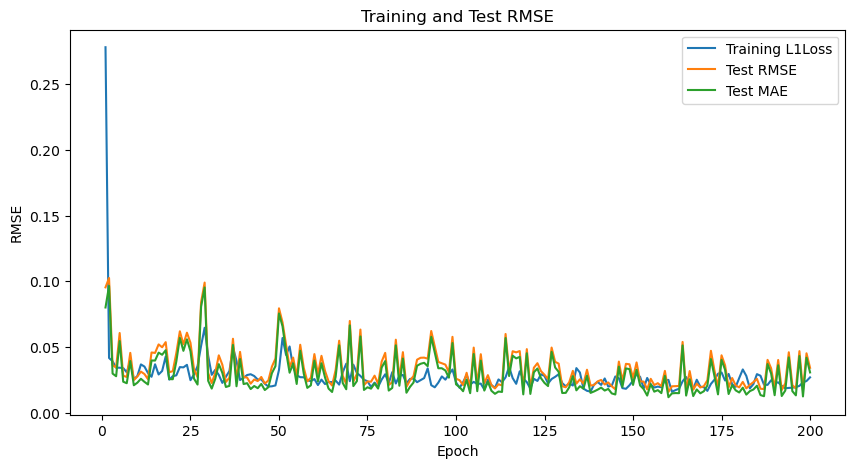

In [14]:
numChannels = XTrain[0].size(0)
numHeads = 4
numHiddenUnits = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)
loss_position=trainLoop(train_loader,test_loader,model,1)

In [15]:
loopNum = 10
#CNN-ATT-POSITION
rmse = [[] for _ in range(loopNum)]
mae = [[] for _ in range(loopNum)]
print("CNN-LSTM")
model = CNN_LSTM_position(numChannels, numHeads, numHiddenUnits).to(device)

for i in range(loopNum):
    _, rmse[i],mae[i]=trainLoop(train_loader,test_loader,model,0)
    print(f"{i+1} / {loopNum} ")
print(f"lowest RMSE: {np.min(rmse)}\n lowest MAE: {np.min(mae)}\n mean RMSE: {np.mean(rmse)}")

CNN-LSTM
1 / 10 
2 / 10 
3 / 10 
4 / 10 
5 / 10 
6 / 10 
7 / 10 
8 / 10 
9 / 10 
10 / 10 
lowest RMSE: 0.00839891517534852
 lowest MAE: 0.006339027546346188
 mean RMSE: 0.01116175353527069



(process:20896): Pango-WARNING **: 19:31:26.824: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


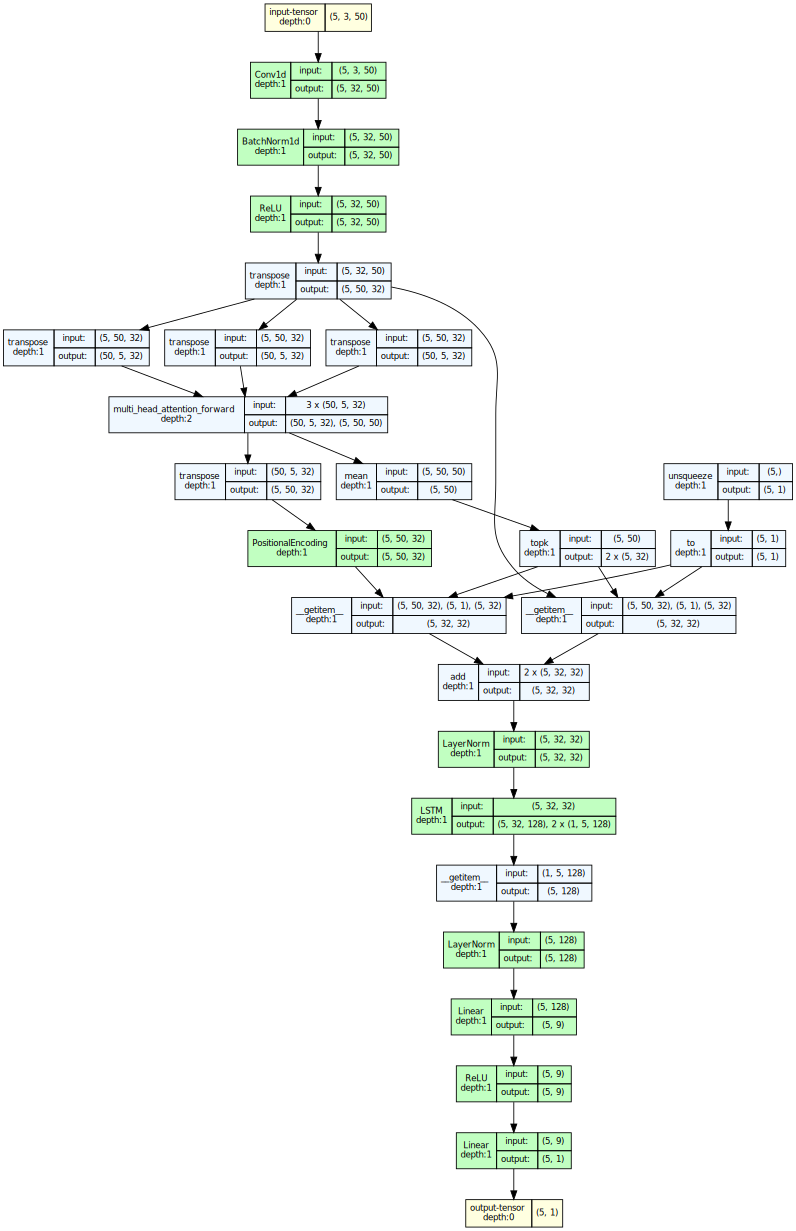

In [16]:
from torchview import draw_graph
numChannels = XTrain[0].size(0)
numHeads = 4
numHiddenUnits = 128
num_epochs = 200
batch_size = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_position_skip(numChannels, numHeads, numHiddenUnits).to(device)
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(5,3,50), device='cuda')
model_graph.visual_graph